In [1]:
# set up a GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
# test GPU working (output should be "Using -- cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print( "Using --", device )

Using -- cuda


In [4]:
# prepare data
class GenDataset( Dataset ):

  def __init__( self, filepath, pred_vars, target_var, trainflag = True ):
    df_csv = pd.read_csv( filepath, index_col=0)

    if( trainflag == True ):
      # extract and build the training data ...
      df = df_csv.loc[ df_csv["train"] == 1, : ]
    else:
      # extract and build test data ...
      df = df_csv.loc[ df_csv["train"] == 0, : ]
    
    x = df.loc[:, pred_vars ].values   # predictor variables 
    y = df.loc[:, target_var].values     # target

    self.x = torch.tensor( x, dtype = torch.float32 )
    self.y = torch.tensor( y, dtype = torch.float32 )

  def __len__(self):
    return len( self.y )

  def __getitem__( self, idx ):
    return self.x[idx], self.y[idx]


# X, Y = make_classification(
#   n_samples=100, n_features=4, n_redundant=0,
#   n_informative=3,  n_clusters_per_class=2, n_classes=3
# )

In [5]:
# load build data set 
filename = '../sim-data/population-sample.csv'

pred_vars_to_use = ["Age", "Sex", "MDD_hx", "Rx_hx", "Py_hx", "Sev", "Dur", "MDD_dx"]
target_var_to_use = ["Offer_Rx"]

# instantiate the data loader for the actual data
train_data = GenDataset( filename, pred_vars_to_use, target_var_to_use, trainflag = True )
test_data = GenDataset( filename, pred_vars_to_use, target_var_to_use, trainflag = False )



In [6]:
print( len( train_data ) )
print( len( test_data ) )

# load into a DataLoader iterator so that accessing will return a batch at a time
batch_size = 30
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_loader = DataLoader(test_data, batch_size= batch_size, shuffle = True, num_workers=2 )


2643
1116


In [7]:
# establish input/output dimensions
train_x, train_y = next(iter(train_loader))

input_size = train_x[0].shape[0]
output_size = train_y[0].shape[0]

print(f" Input size = {input_size}")
print(f" Target size = {output_size}")

 Input size = 8
 Target size = 1


In [8]:
# network definition 

# number of hidden nodes
hidden_size = 25


# class Network2(nn.Module):
#   def __init__(self):
#     super(Network2, self).__init__()
#     self.linear1 = nn.Linear(input_size, hidden_size)
#     self.linear2 = nn.Linear(hidden_size, output_size)
  
#   def forward_layer1( self, x ):
#     x = torch.sigmoid(self.linear1(x))
#     return x
  
#   def forward_layer2( self, x ):
#     x = self.linear2(x)
#     return x 
  
#   def forward(self, x):
#     y = self.forward_layer1(x)
#     y = self.forward_layer2(y)
#     return y
    

class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward_layer1( self, x ):
        y = self.linear(x)
        return y

    def forward_layer2( self, x ):
        y = torch.sigmoid(x)
        return y 
    
    def forward( self, x ):
        y = self.forward_layer1( x )
        y = self.forward_layer2( y )
        return( y )




In [9]:
# learning params
learn_rate = 0.01

# instantiate network
model = Network1()
print( model.parameters )

# define loss and optimizer algorithm
criterion = nn.BCELoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)


<bound method Module.parameters of Network1(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)>


In [10]:
# load stuff onto GPU
model.to(device)

Network1(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [11]:
print( batch_size )

30


In [12]:
epochs = 100

train_loss_epoch = np.zeros(epochs)
test_loss_epoch = np.zeros(epochs)

N_train = len( train_data )
N_test = len( test_data )



for epoch in range(epochs):
  train_running_loss = 0.0
  test_running_loss = 0.0
  
  # training for one epoch
  model.train()
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    train_running_loss += loss.item()

  # out-of-sample performance for one epoch of training
  model.eval()
  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
      test_outputs = model( test_inputs )
      test_loss = criterion( test_outputs, test_labels )
      test_running_loss = test_loss.item() * test_labels.size(0)

  train_loss_epoch[epoch] = train_running_loss / len( train_loader ) 
  test_loss_epoch[epoch]  = test_running_loss / len( test_loader )
  print("Completed Epoch ", epoch)



Completed Epoch  0
Completed Epoch  1
Completed Epoch  2
Completed Epoch  3
Completed Epoch  4
Completed Epoch  5
Completed Epoch  6
Completed Epoch  7
Completed Epoch  8
Completed Epoch  9
Completed Epoch  10
Completed Epoch  11
Completed Epoch  12
Completed Epoch  13
Completed Epoch  14
Completed Epoch  15
Completed Epoch  16
Completed Epoch  17
Completed Epoch  18
Completed Epoch  19
Completed Epoch  20
Completed Epoch  21
Completed Epoch  22
Completed Epoch  23
Completed Epoch  24
Completed Epoch  25
Completed Epoch  26
Completed Epoch  27
Completed Epoch  28
Completed Epoch  29
Completed Epoch  30
Completed Epoch  31
Completed Epoch  32
Completed Epoch  33
Completed Epoch  34
Completed Epoch  35
Completed Epoch  36
Completed Epoch  37
Completed Epoch  38
Completed Epoch  39
Completed Epoch  40
Completed Epoch  41
Completed Epoch  42
Completed Epoch  43
Completed Epoch  44
Completed Epoch  45
Completed Epoch  46
Completed Epoch  47
Completed Epoch  48
Completed Epoch  49
Completed 

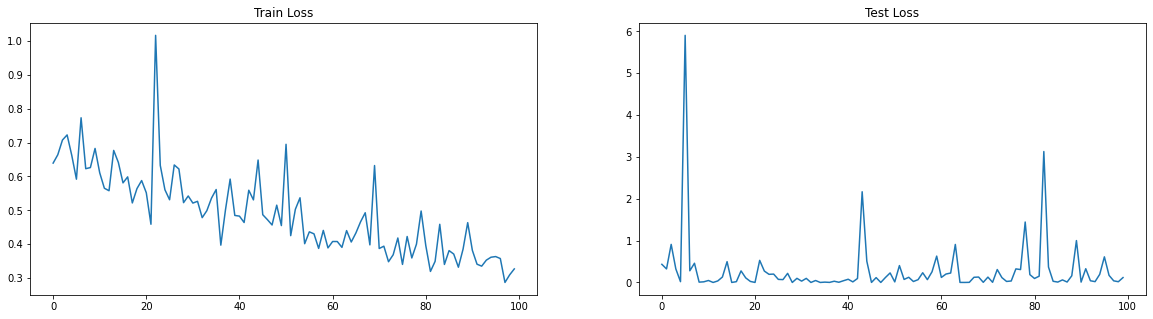

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots( 1,2, figsize = (20, 5) )
ax1.plot( list(range(0,len(train_loss_epoch))), train_loss_epoch )
ax2.plot( list(range(0,len(train_loss_epoch))), test_loss_epoch )
ax1.title.set_text('Train Loss')
ax2.title.set_text('Test Loss')

In [ ]:
# save network state for later re-use
PATH = '../net-states/testing-only.pth'
torch.save(clf.state_dict(), PATH)


In [ ]:

# load network state 
clf = None

clf = Network()
clf.load_state_dict( torch.load(PATH))



In [ ]:
# instantiate data loader for test data
testdata = Data(X_test, Y_test)
testloader = DataLoader(testdata, batch_size=batch_size, 
                        shuffle=True, num_workers=2)

In [ ]:
# a single run of inference / forward prop only
outputs = clf(inputs)
print( outputs )

In [ ]:
# apply max over 3 tuple (outputs) -- note, indexing starts at 0, so remember to add one

__, predicted = torch.max(outputs, dim = 1)
print(predicted)


In [ ]:
# complete run through testing data set

correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    # calculate output by running through the network
    outputs = clf(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct // total} %')